# Test out standardized ADCIRC, SELFE and FVCOM  datasets with pyugrid, IRIS and Cartopy

The datasets being accessed here are NetCDF files from ADCIRC, SELFE and FVCOM, with attributes added or modified virtually using NcML to meet the [UGRID conventions standard for unstructured grid models](https://github.com/ugrid-conventions/ugrid-conventions/blob/v0.9.0/ugrid-conventions.md). 

This example was developed for the Integrated Ocean Observing System (IOOS) Coastal and Ocean Modeling Testbed. 

You can quickly and easily [set up the IOOS Anaconda python environment that can run this notebook](https://github.com/ioos/conda-recipes/wiki).

In [1]:
%matplotlib inline
from __future__ import (absolute_import, division, print_function)
import numpy as np
import matplotlib.tri as tri
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
import cartopy.crs as ccrs
import iris
iris.FUTURE.netcdf_promote = True
import pyugrid

In [3]:
# specify UGRID compliant OPeNDAP Data URL

#ADCIRC
#url = 'http://comt.sura.org/thredds/dodsC/data/comt_1_archive/inundation_tropical/UND_ADCIRC/Hurricane_Rita_2D_final_run_without_waves'

#ESTOFS
url = 'http://coastalmodeldev.data.noaa.gov/thredds/dodsC/aggregAtlanticESTOFS'

#FVCOM
#url = 'http://comt.sura.org/thredds/dodsC/data/comt_1_archive/inundation_tropical/USF_FVCOM/Hurricane_Rita_2D_final_run_without_waves'

#SELFE
#url = 'http://comt.sura.org/thredds/dodsC/data/comt_1_archive/inundation_tropical/VIMS_SELFE/Hurricane_Rita_2D_final_run_without_waves'

# set parameters
bbox = [-95, -85, 27, 32]                  # set the bounding box [lon_min, lon_max, lat_min, lat_max]
var = 'sea_surface_height_above_geoid'     # standard_name (or long_name, if no standard_name)
levs = np.arange(-0.5,.55,.05)                # set the contour levels
#start = dt.datetime(2005, 9, 24, 5, 0, 0)  # time in UTC
start = dt.datetime.utcnow() + dt.timedelta(hours=6)

In [4]:
cube = iris.load_cube(url,var)

/home/usgs/miniconda/envs/ioos/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1300: UserWarning: Ignoring netCDF variable u'nbdv' invalid units u'nondimensional'
  warnings.warn(msg.encode('ascii', errors='backslashreplace'))
/home/usgs/miniconda/envs/ioos/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1300: UserWarning: Ignoring netCDF variable u'neta' invalid units u'nondimensional'
  warnings.warn(msg.encode('ascii', errors='backslashreplace'))
/home/usgs/miniconda/envs/ioos/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1441: UserWarning: Failed to create 'time' dimension coordinate: The points array must be strictly monotonic.
Gracefully creating 'time' auxiliary coordinate instead.
  error=e_msg))
/home/usgs/miniconda/envs/ioos/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1300: UserWarning: Ignoring netCDF variable u

In [5]:
print(cube)

sea_surface_height_above_geoid / (m) (-- : 768; -- : 254565)
     Auxiliary coordinates:
          time                           x         -
          latitude                       -         x
          longitude                      -         x
     Attributes:
          Conventions: CF-1.4, UGRID-0.9
          NCO: 4.3.7
          a00: 0.35
          b00: 0.3
          c00: 0.35
          cdm_data_type: ugrid
          cf: 0.0025
          comments: ESTOFS ATLANTIC V1.0.0
          contact: yuji.funakoshi@noaa.gov
          cori: 0.0
          coverage_content_type: modelResult
          creation_date: 2015-12-14  4:27:03  00:00
          description: 2015121400
          dramp: 0.0
          dt: 5.0
          eslm: 5.0
          fort.15: ==== Input File Parameters (below) ====
          grid: ec2001_v2e.grd
          grid_type: Triangular
          h0: 0.25
          history: Mon Dec 14 06:14:18 2015: ncks -d time,0,5 /opt/thredds/data/estofs/datapool/20151214.estofs.atl.t00z.fiel

In [6]:
ug = pyugrid.UGrid.from_ncfile(url)

# What's in there?
print('There are {0} nodes'.format(ug.nodes.shape[0]))
print('There are {0} faces'.format(ug.faces.shape[0]))

There are 254565 nodes
There are 492179 faces


In [7]:
cube.mesh = ug

In [8]:
lon = cube.mesh.nodes[:,0]
lat = cube.mesh.nodes[:,1]
nv = cube.mesh.faces

In [9]:
triang = tri.Triangulation(lon,lat,triangles=nv)

In [10]:
tvar = cube.coord('time')
itime = tvar.nearest_neighbour_index(tvar.units.date2num(start))

In [11]:
zcube = cube[itime]

/home/usgs/miniconda/envs/ioos/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/usgs/miniconda/envs/ioos/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


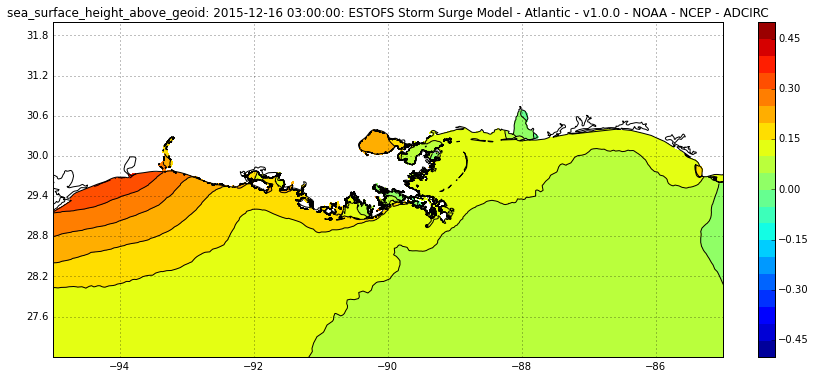

In [12]:
plt.figure(figsize=(16,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(bbox)
ax.coastlines(resolution='10m')
plt.tricontourf(triang, zcube.data, levels=levs)
plt.colorbar(fraction=0.046, pad=0.04)
plt.tricontour(triang, zcube.data, colors='k',levels=levs)
tstr = tvar.units.num2date(tvar.points[itime])
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
plt.title('{}: {}: {}'.format(var,tstr,zcube.attributes['title']));